In [5]:
from glob import glob
import fnmatch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow

C:\Users\iwin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\iwin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\iwin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\iwin\AppData\Roaming\Python\Python37\site-pack

In [3]:
import keras

Using TensorFlow backend.


In [6]:
imagePatches = glob('D:\DataAnalysisRyerson\CKME136_Capstone\Resources\Breast cancer\**\*.png', recursive=True)

In [7]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero) #saves the file location of all images with file name class0
classOne = fnmatch.filter(imagePatches, patternOne) #saves the file location of all images with file name class1

In [8]:
def process_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    height = 50
    width = 50
    channels = 3
    x = [] #list to store image data
    y = [] #list to store corresponding class
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        image = (cv2.resize(full_size_image, (width,height), interpolation=cv2.INTER_CUBIC))
        x.append(image)
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [9]:
X, Y = process_images(0,60000)

In [10]:
X = np.array(X)

In [11]:
X = X.astype(np.float32) #Casting the array to single precision takes half as much space

In [12]:
X /= 255. #Normalizing, which helps train the model faster and prevents the vanishing/ exploding gradient problem

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.15)

In [15]:
Y.count(0) #Checking the number of 0's in the array Y (this denotes number of malignant cases)

44478

In [16]:
Y.count(1) #Checking the number of 1's in the array Y (this denotes number of malignant cases)

15522

In [17]:
y_train.count(1) #Checking the number of 1's in the array y_train

13226

In [18]:
y_train.count(0) #Checking the number of 0's in the array y_train

37774

In [19]:
from keras.utils import to_categorical

In [20]:
#One-Hot-Encode y_train and y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

---

Dealing with Class ImBalance

In [21]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [25]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler(sampling_strategy='majority')
X_trainRus, Y_trainRus = random_under_sampler.fit_sample(X_trainFlat, y_train)
X_testRus, Y_testRus = random_under_sampler.fit_sample(X_testFlat, y_test)

D:\Anaconda\envs\IwinEnv\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Anaconda\envs\IwinEnv\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [26]:
# One-hot-encoding
Y_trainRusHot = to_categorical(Y_trainRus, num_classes = 2)
Y_testRusHot = to_categorical(Y_testRus, num_classes = 2)

In [27]:
np.unique(Y_trainRus, return_counts=True) #checking the number of samples in each class to make sure RandomUnderSampling worked

(array([0, 1]), array([13226, 13226], dtype=int64))

In [28]:
for i in range(len(X_trainRus)):
    height, width, channels = 50,50,3
    X_trainRusReshaped = X_trainRus.reshape(len(X_trainRus),height,width,channels)

In [29]:
for i in range(len(X_testRus)):
    height, width, channels = 50,50,3
    X_testRusReshaped = X_testRus.reshape(len(X_testRus),height,width,channels)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [31]:
batch_size = 256
num_classes = 2
epochs = 80

In [32]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Flatten()) #this converts our 3D feature maps to 1D feature vectors for the dense layer below
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

In [33]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    horizontal_flip=True,vertical_flip = True)

In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [36]:
training = model.fit_generator(datagen.flow(X_trainRusReshaped,Y_trainRusHot,batch_size=batch_size),
                    steps_per_epoch=len(X_trainRusReshaped) / batch_size, epochs=epochs,validation_data=(X_testRusReshaped, Y_testRusHot), verbose=1, callbacks=[early_stopping_monitor, model_checkpoint])


Epoch 1/80


D:\Anaconda\envs\IwinEnv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda\envs\IwinEnv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


104/103 [==============================] - 19s 178ms/step - loss: 0.6911 - accuracy: 0.5057 - val_loss: 0.6850 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.68501, saving model to best_model.h5
Epoch 2/80
104/103 [==============================] - 14s 135ms/step - loss: 0.6565 - accuracy: 0.6367 - val_loss: 0.5791 - val_accuracy: 0.7626

Epoch 00002: val_loss improved from 0.68501 to 0.57911, saving model to best_model.h5
Epoch 3/80
104/103 [==============================] - 14s 136ms/step - loss: 0.5388 - accuracy: 0.7607 - val_loss: 0.4924 - val_accuracy: 0.7779

Epoch 00003: val_loss improved from 0.57911 to 0.49243, saving model to best_model.h5
Epoch 4/80
104/103 [==============================] - 14s 135ms/step - loss: 0.5012 - accuracy: 0.7766 - val_loss: 0.4900 - val_accuracy: 0.7798

Epoch 00004: val_loss improved from 0.49243 to 0.48997, saving model to best_model.h5
Epoch 5/80
104/103 [==============================] - 14s 136ms/step - loss: 0.4949 - a

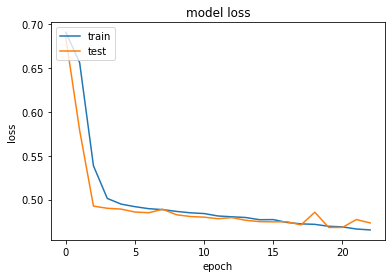

In [37]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
from keras.models import load_model
from sklearn import metrics
model = load_model('best_model.h5')

y_pred_one_hot = model.predict(X_testRusReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)

y_true_labels = np.argmax(Y_testRusHot,axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

InternalError: GPU sync failed